In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [ ]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Questão 1

In [ ]:
padroes = {
    (0, 0, 0): 0,
    (0, 0, 1): 1,
    (0, 1, 0): 2,
    (0, 1, 1): 3,
    (1, 0, 0): 4,
    (1, 0, 1): 5,
    (1, 1, 0): 6,
    (1, 1, 1): 7
}
def criar_dataset_aleatorio(num_padroes):
    dataset = []

    for i in range(num_padroes):
        x = np.array([random.choice([0, 1]) for _ in range(3)])
        y = padroes.get(tuple(x))
        noise = np.array([random.uniform(-0.1, 0.1) for _ in range(3)])
        dataset.append(np.r_[x + noise, int(y)])

    dataset = np.array(dataset)
    assert dataset.shape[0] == np.unique(dataset, axis=0).shape[0]

    return dataset

# Exemplo de uso da função com 5 padrões
dataset = criar_dataset_aleatorio(1000000)

In [ ]:
train_df = dataset[:700000]
val_df = dataset[700000:800000]
test_df = dataset[800000:]

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(700000, 4)
(100000, 4)
(200000, 4)


In [ ]:
val_df.shape

(100000, 4)

In [ ]:
train_tensor = torch.tensor(train_df)
val_tensor = torch.tensor(val_df)
test_tensor = torch.tensor(test_df)

In [ ]:
class CubeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx, :3]
        y = self.data[idx, 3]
        return X, y

In [ ]:
train_dataloader = DataLoader(CubeDataset(train_tensor), batch_size=1024)
val_dataloader = DataLoader(CubeDataset(val_tensor), batch_size=1024)
test_dataloader = DataLoader(CubeDataset(test_tensor), batch_size=1024)

In [ ]:
class RosemblattPerceptron(nn.Module):
    def __init__(self):
        super(RosemblattPerceptron, self).__init__()
        self.perceptron = nn.Linear(3, 8, dtype=torch.float64)

    def forward(self, x):
        x = self.perceptron(x)
        output = F.softmax(x, dim=1, dtype=torch.float64)
        return output

In [ ]:
model = RosemblattPerceptron().to(device)
print(model)

RosemblattPerceptron(
  (perceptron): Linear(in_features=3, out_features=8, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update dos gradientes pra atualizar os pesos.
        optimizer.zero_grad() # Zera o gradiente pro proximo

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Passa o modelo pro modo de eval
    test_loss, correct = 0, 0
    with torch.no_grad(): # Nao vai mais calcular o gradiente pra fazer a descida, uma vez que estamos no teste
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 26
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.093838  [ 1024/700000]
loss: 2.086256  [103424/700000]
loss: 2.078388  [205824/700000]
loss: 2.068418  [308224/700000]
loss: 2.058466  [410624/700000]
loss: 2.049772  [513024/700000]
loss: 2.030524  [615424/700000]
Test Error: 
 Accuracy: 25.0%, Avg loss: 2.028220 

Epoch 2
-------------------------------
loss: 2.029694  [ 1024/700000]
loss: 2.021905  [103424/700000]
loss: 2.008110  [205824/700000]
loss: 1.996067  [308224/700000]
loss: 1.983048  [410624/700000]
loss: 1.975093  [513024/700000]
loss: 1.947849  [615424/700000]
Test Error: 
 Accuracy: 25.0%, Avg loss: 1.958876 

Epoch 3
-------------------------------
loss: 1.962396  [ 1024/700000]
loss: 1.960393  [103424/700000]
loss: 1.946508  [205824/700000]
loss: 1.936399  [308224/700000]
loss: 1.924214  [410624/700000]
loss: 1.914450  [513024/700000]
loss: 1.886037  [615424/700000]
Test Error: 
 Accuracy: 43.0%, Avg loss: 1.896750 

Epoch 4
-------------------------------
loss: 1.902435 

# Questão 2

## a) XOR

In [ ]:
Xs = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])

y = torch.Tensor([0., 1., 1., 0.]).reshape(Xs.shape[0], 1)

In [ ]:
Xy = torch.cat((Xs, y), 1) # Junta os tensores

In [ ]:
class XorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx, :2]
        y = self.data[idx, 2]
        return X, y

In [ ]:
train_dataloader = DataLoader(XorDataset(Xy))
val_dataloader = DataLoader(XorDataset(Xy))

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.linear = nn.Linear(2, 2, dtype=torch.float64)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1, dtype=torch.float64)

    def forward(self, input):
      x = self.linear(input)
      sig = self.Sigmoid(x)
      yh = self.linear2(sig)
      return yh

model = MultiLayerPerceptron().to(device)
print(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.DoubleTensor)
        # talvez pra resolver o mat1 e mat2 error, precisamos passar o X pra float64 tbm (Precisa conferir o tipo na verdade)
        X = X.to(torch.float64)

        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update print(torch.round(pred[0]))
        optimizer.zero_grad() # Zera o gradiente pro proximo

        loss_list.append(loss.item())

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss_list

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    loss_list = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(torch.float64)
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_at_this_iteration = loss_fn(pred, y).item()
            test_loss += loss_at_this_iteration
            loss_list.append(loss_at_this_iteration)
            correct += (torch.round(pred[0]) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return loss_list

MultiLayerPerceptron(
  (linear): Linear(in_features=2, out_features=2, bias=True)
  (Sigmoid): Sigmoid()
  (linear2): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
epochs = 1000
loss_total_train = []
loss_total_eval = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, loss_fn, optimizer)
    loss_total_train.append(np.mean(loss_train))
    loss_eval = test(val_dataloader, model, loss_fn)
    loss_total_eval.append(np.mean(loss_eval))
print("Done!")

Epoch 1
-------------------------------
loss: 0.163652  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.938017 

Epoch 2
-------------------------------
loss: 0.134721  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.884167 

Epoch 3
-------------------------------
loss: 0.110849  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.834005 

Epoch 4
-------------------------------
loss: 0.089815  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.787348 

Epoch 5
-------------------------------
loss: 0.071448  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.744025 

Epoch 6
-------------------------------
loss: 0.055595  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.703832 

Epoch 7
-------------------------------
loss: 0.042094  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.666536 

Epoch 8
-------------------------------
loss: 0.030776  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.631897 

Epoch 9
----------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.

Epoch 168
-------------------------------
loss: 0.233388  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250527 

Epoch 169
-------------------------------
loss: 0.233385  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250521 

Epoch 170
-------------------------------
loss: 0.233382  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250515 

Epoch 171
-------------------------------
loss: 0.233379  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250509 

Epoch 172
-------------------------------
loss: 0.233375  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250503 

Epoch 173
-------------------------------
loss: 0.233371  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250497 

Epoch 174
-------------------------------
loss: 0.233367  [    1/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250491 

Epoch 175
-------------------------------
loss: 0.233362  [    1/    4]
Test Err

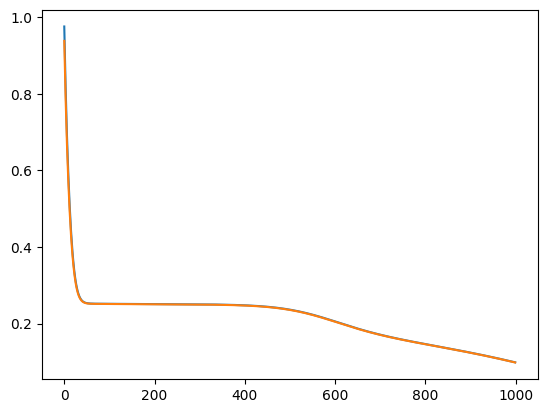

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_total_train, )
plt.plot(loss_total_eval)

In [ ]:
# test input
input = torch.Tensor(
    [[0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.]]
).type(torch.DoubleTensor).to(device)

out = model(input)
# print(out.round())
# plt.plot(input.cpu()[:, 0], input.cpu()[:, 1], "o")
# plt.plot()
out.round().cpu().detach().numpy()

array([[0.],
       [1.],
       [1.],
       [1.]])

## b) Log

In [ ]:
def log_func(n):
    x = np.linspace(0.1, 10, n).reshape(-1, 1)
    y = np.log10(x)

    return np.c_[x, y]

dataset = log_func(5000)

In [ ]:
dataset.shape

(5000, 2)

In [ ]:
class LogDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx, :1]
        y = self.data[idx, 1]
        return X, y

In [ ]:
from sklearn.model_selection import train_test_split

size = len(dataset)
train_df = torch.Tensor(dataset[:int(size*0.85)])
eval_df = torch.Tensor(dataset[int(size*0.85):])


In [ ]:
train_dataloader = DataLoader(
    LogDataset(train_df),
    batch_size=64
)

val_dataloader = DataLoader(
    LogDataset(eval_df),
    batch_size=64
)

In [ ]:
class LogMultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(LogMultiLayerPerceptron, self).__init__()
        self.linear = nn.Linear(1, 128, dtype=torch.float64)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(128, 1, dtype=torch.float64)

    def forward(self, input):
      x = self.linear(input)
      x = self.Sigmoid(x)
      x = self.linear2(x)

      return x

model = LogMultiLayerPerceptron().to(device)
print(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.DoubleTensor)
        # talvez pra resolver o mat1 e mat2 error, precisamos passar o X pra float64 tbm (Precisa conferir o tipo na verdade)
        X = X.to(torch.float64).reshape(-1, 1)
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update print(torch.round(pred[0]))
        optimizer.zero_grad() # Zera o gradiente pro proximo

        loss_list.append(loss.item())

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss_list

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    loss_list = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(torch.float64).reshape(-1, 1)
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_at_this_iteration = loss_fn(pred, y).item()
            print(loss_at_this_iteration)
            test_loss += loss_at_this_iteration
            loss_list.append(loss_at_this_iteration)
            # correct += (pred[0] - y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return loss_list

LogMultiLayerPerceptron(
  (linear): Linear(in_features=1, out_features=128, bias=True)
  (Sigmoid): Sigmoid()
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
epochs = 500
loss_total_train = []
loss_total_eval = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, loss_fn, optimizer)
    loss_total_train.append(np.mean(loss_train))
    loss_eval = test(val_dataloader, model, loss_fn)
    loss_total_eval.append(np.mean(loss_eval))
print("Done!")

Epoch 1
-------------------------------
loss: 0.447018  [   64/ 4250]
0.8350268065481599
0.8361378630805657
0.8371714107684902
0.8381300900945318
0.8390164943891398
0.8398331650787261
0.8405825865868056
0.8412671843653377
0.8418893220753605
0.8424512996985007
0.8429553524859327
0.8251563684721478
Test Error: 
 Avg loss: 0.838301 

Epoch 2
-------------------------------
loss: 2.680000  [   64/ 4250]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Streaming output truncated to the last 5000 lines.
0.8901867929887832
0.8999919495439734
0.9095850976105835
0.9189748658178979
0.9281696086402424
0.9371773795441164
0.9460058958305582
0.9546625137490926
0.9631542146427087
0.9492389088571778
Test Error: 
 Avg loss: 0.920601 

Epoch 224
-------------------------------
loss: 0.016991  [   64/ 4250]
0.8687849477698423
0.8789555798336061
0.888898121984939
0.898621753163839
0.9081355045915043
0.9174482010032574
0.9265683971380835
0.9355043492211643
0.9442639782898036
0.952854843795288
0.9612841282464214
0.9473603397740094
Test Error: 
 Avg loss: 0.919057 

Epoch 225
-------------------------------
loss: 0.017095  [   64/ 4250]
0.8683015206656983
0.8783290036302258
0.8881304770577925
0.8977154195412504
0.9070931550539201
0.9162727937729962
0.9252631683448296
0.9340728047500662
0.9427098852287523
0.9511822214260075
0.9594972385090235
0.945520325633371
Test Error: 
 Avg loss: 0.917841 

Epoch 226
-------------------------------
loss: 0.017867  

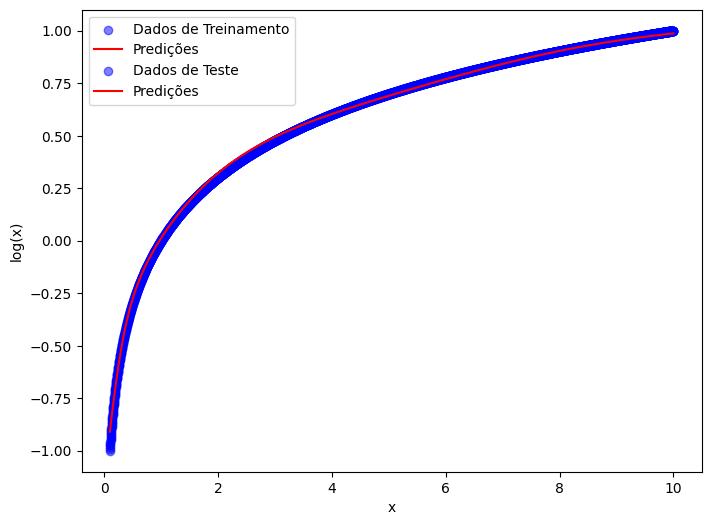

In [ ]:
# # Avaliar o desempenho da rede
x_test = train_df[:, 0].reshape(-1, 1)
y_pred = model(x_test.to(device).to(torch.float64))

# # Avaliar o desempenho da rede
x_eval = eval_df[:, 0].reshape(-1, 1)
y_eval = model(x_eval.to(device).to(torch.float64))

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(train_df[:,0], train_df[:,1], label='Dados de Treinamento', color="blue", alpha=0.5)
plt.plot(x_test, y_pred.cpu().detach().numpy(), label='Predições', color='red')
plt.scatter(eval_df[:,0], eval_df[:,1], label='Dados de Teste', color="blue", alpha=0.5)
plt.plot(x_eval, y_eval.cpu().detach().numpy(), label='Predições', color='red')
plt.xlabel('x')
plt.ylabel('log(x)')
plt.legend()
plt.show()

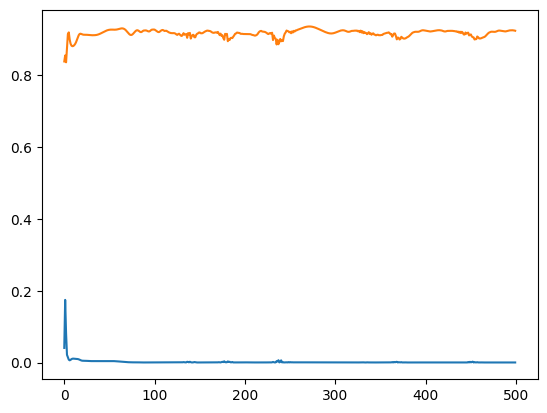

In [ ]:
plt.plot(loss_total_train, label='Erro do treino')
plt.plot(loss_total_eval, label='Erro do teste')
plt.legend()
plt.show()

## C) - Polinômio

f(x) = 10x^5+ 5x^4+ 2x^3 – 0.5x^2+ 3x + 2

onde 0 ≤ x ≤ 8

In [ ]:
def polinomial_func(n):
    x = np.linspace(0, 8, n).reshape(-1, 1)
    f = lambda x: 10*(x**5) + 5*(x**4) + 2*(x**3) - 0.5*(x**2) + 3*x + 2
    y = f(x)
    return list(zip(x, y))

polinomial_dataset = polinomial_func(2000)

In [ ]:
train_dataset, test_dataset = train_test_split(polinomial_dataset, test_size=0.2)

In [ ]:
loaders = {
    'train': DataLoader(
        train_dataset,
        batch_size=32,
    ),
    'test': DataLoader(
        test_dataset,
        batch_size=32,
    )
}

In [ ]:
class PoynomialModel(nn.Module):
    def __init__(self):
        super(PoynomialModel, self).__init__()
        self.linear = nn.Linear(1, 128, dtype=torch.float32)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(128, 64, dtype=torch.float32)
        self.ReLU2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 1, dtype=torch.float32)

    def forward(self, input):
      x = self.linear(input)
      x = self.ReLU(x)
      x = self.linear2(x)
      x = self.ReLU2(x)
      x = self.linear3(x)
      return x


# class PoynomialModel(nn.Module):
#     def __init__(self):
#         super(PoynomialModel, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(1, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         return self.layers(x)

In [ ]:
model = PoynomialModel().to(device)
print(model)
loss_fn = nn.MSELoss() #L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8, nesterov=True)

loss_list = []

def train(loader, model, loss_fn, optimizer):
  # model.train() # Seta o modelo como "treinável"

  for X, y in loader['train']:
    # Transforma os tipos
    y = y.type(torch.FloatTensor)
    X = X.to(torch.float32).reshape(-1, 1)

    # Manda pra GPU
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad() # Antes de qualquer coisa zera o grad
    # Faz a predição e calcula o loss
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward() # Backpropagation
    optimizer.step() # Faz o update

    loss_list.append(loss.item())

    return loss_list

def test(loader, model, loss_fn):
    num_batches = len(loader)
    # model.eval()
    test_loss, correct = 0, 0
    loss_list = []
    with torch.no_grad():
        for X, y in loader['test']:
            y = y.type(torch.FloatTensor)
            X = X.to(torch.float32).reshape(-1, 1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_at_this_iteration = loss_fn(pred, y).item()
            test_loss += loss_at_this_iteration
            loss_list.append(loss_at_this_iteration)
            # correct += (pred[0] - y).type(torch.float).sum().item()
    # print(num_batches)
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return loss_list

PoynomialModel(
  (linear): Linear(in_features=1, out_features=128, bias=True)
  (ReLU): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (ReLU2): ReLU()
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
epochs = 5000
loss_total_train = []
loss_total_eval = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(loaders, model, loss_fn, optimizer)
    loss_total_train.append(np.mean(loss_train))

    loss_eval = test(loaders, model, loss_fn)
    loss_total_eval.append(np.mean(loss_eval))
print("Done!")

A saída de streaming foi truncada nas últimas 5000 linhas.
-------------------------------
Test Error: 
 Avg loss: 24041587.046875 

Epoch 4002
-------------------------------
Test Error: 
 Avg loss: 24089073.531250 

Epoch 4003
-------------------------------
Test Error: 
 Avg loss: 24029484.671875 

Epoch 4004
-------------------------------
Test Error: 
 Avg loss: 24091013.093750 

Epoch 4005
-------------------------------
Test Error: 
 Avg loss: 24037951.703125 

Epoch 4006
-------------------------------
Test Error: 
 Avg loss: 24075658.468750 

Epoch 4007
-------------------------------
Test Error: 
 Avg loss: 24058091.156250 

Epoch 4008
-------------------------------
Test Error: 
 Avg loss: 24055230.328125 

Epoch 4009
-------------------------------
Test Error: 
 Avg loss: 24076712.375000 

Epoch 4010
-------------------------------
Test Error: 
 Avg loss: 24042282.171875 

Epoch 4011
-------------------------------
Test Error: 
 Avg loss: 24083987.218750 

Epoch 4012
------

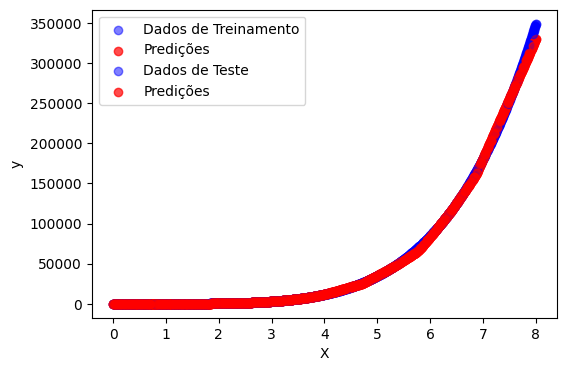

In [ ]:
# Avaliar o desempenho da rede
h = lambda x: x[0]
j = lambda x: x[1]

x_test = list(map(h, train_dataset)) #.reshape(-1, 1)
y_test = list(map(j, train_dataset))
y_pred = model(torch.tensor(x_test).to(device).to(torch.float32))

# # Avaliar o desempenho da rede
x_eval = list(map(h, test_dataset))
y_eval = list(map(j, test_dataset))
y_pred_eval = model(torch.tensor(x_eval).to(device).to(torch.float32))

# Plotar os resultados
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, label='Dados de Treinamento', color="blue", alpha=0.5)
plt.scatter(x_test, y_pred.cpu().detach().numpy(), label='Predições treino', color='red', alpha=0.7)
plt.scatter(x_eval, y_eval, label='Dados de Teste', color="blue", alpha=0.5)
plt.scatter(x_eval, y_pred_eval.cpu().detach().numpy(), label='Predições teste', color='red', alpha=0.7)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

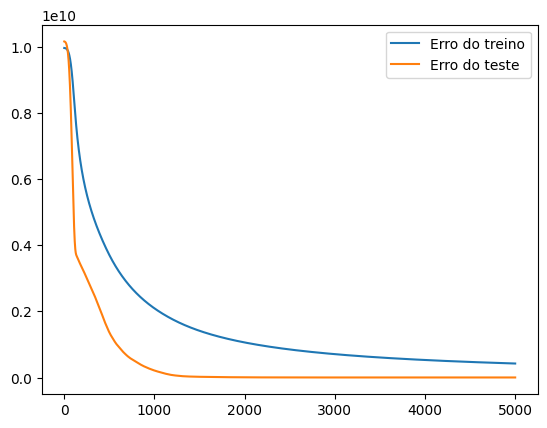

In [ ]:
plt.plot(loss_total_train, label='Erro do treino')
plt.plot(loss_total_eval, label='Erro do teste')
plt.legend()
plt.show()

# Questão 3

In [ ]:
def calcular_y_do_ponto_da_reta(ponto1, ponto2, x):
    x1, y1 = ponto1
    x2, y2 = ponto2

    # Calcula o coeficiente angular (slope)
    if x2 - x1 == 0:
        return [(x1, y) for y in range(min(y1, y2), max(y1, y2) + 1)]
    else:
        m = (y2 - y1) / (x2 - x1)

        # Calcula o coeficiente linear (intercept)
        b = y1 - m * x1

        # Calcula o ponto
        y = m * x + b

        return y

In [ ]:
def pontos_dentro_do_circulo(centro=(0,0), raio=1,k=100):
    x = []
    y = []
    cx, cy = centro
    for x_ in np.linspace(-1, 1, k, endpoint=0):
        for y_ in np.linspace(-1, 1, k, endpoint=0):
            if math.sqrt((x_ - cx) ** 2 + (y_ - cy) ** 2) <= raio: # formula reduzida da circunferencia, verificando se os pontos estão dentro.
                x.append(x_)
                y.append(y_)
    return x,y

In [ ]:
def criar_dataset_random(n_ex):

    dataset = []

    x,y = pontos_dentro_do_circulo(k=n_ex) # gerandos os pontos

    # Classificação dos pontos
    for i in range(len(x)):
      x_ = x[i]
      y_ = y[i]

      # verificando se o ponto esta em C1
      if x_ > 0 and y_ > 0 and y_ < calcular_y_do_ponto_da_reta((0,1),(1,0),x_):
        dataset.append([x[i],y[i], 0])
        continue

      # verificando se o ponto esta em C2
      if x_ < 0 and y_ > 0 and y_ < calcular_y_do_ponto_da_reta((0,1),(-1,0),x_):
        dataset.append([x[i],y[i], 1])
        continue

      # verificando se o ponto esta em C3
      if x_ < 0 and y_ < 0 and y_ > calcular_y_do_ponto_da_reta((0,-1),(-1,0),x_):
        dataset.append([x[i],y[i], 2])
        continue

      # verificando se o ponto esta em C4
      if x_ > 0 and y_ < 0 and y_ > calcular_y_do_ponto_da_reta((0,-1),(1,0),x_):
        dataset.append([x[i],y[i], 3])
        continue

      # verificando se o ponto esta em C5
      if x_ > 0 and y_ > 0 and y_ > calcular_y_do_ponto_da_reta((0,1),(1,0),x_):
        dataset.append([x[i],y[i], 4])
        continue

      # verificando se o ponto esta em C6
      if x_ < 0 and y_ > 0 and y_ > calcular_y_do_ponto_da_reta((0,1),(-1,0),x_):
        dataset.append([x[i],y[i],5])
        continue

      # verificando se o ponto esta em C7
      if x_ < 0 and y_ < 0 and y_ < calcular_y_do_ponto_da_reta((0,-1),(-1,0),x_):
        dataset.append([x[i],y[i],6])
        continue

      # verificando se o ponto esta em C8
      if x_ > 0 and y_ < 0 and y_ < calcular_y_do_ponto_da_reta((0,-1),(1,0),x_):
        dataset.append([x[i],y[i],7])
        continue

    return dataset

In [ ]:
data = criar_dataset_random(150)

In [ ]:
x=[]
y=[]
z=[]

for i in data:
  x.append(i)
  y.append(i)
  z.append(i)

In [ ]:
data = np.array(data)

In [ ]:
data.shape

(17246, 3)

In [ ]:
df = pd.DataFrame(data, columns = ['x','y','classe'])

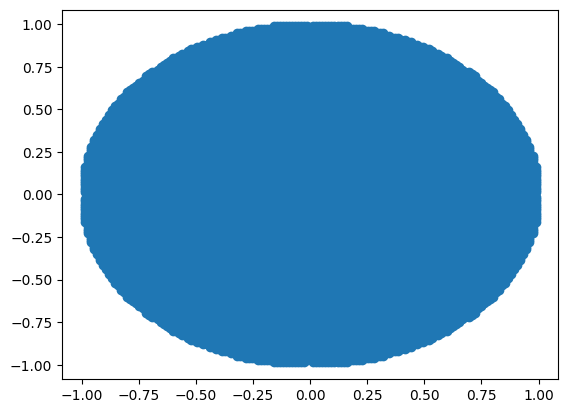

In [ ]:
plt.scatter(df['x'],df['y'])

In [ ]:
import plotly.express as px
fig = px.scatter(df, x = "x", y = "y", color = 'classe',size_max = 60, width = 800)
fig.show()

In [ ]:
data

array([[-0.98666667, -0.16      ,  6.        ],
       [-0.98666667, -0.14666667,  6.        ],
       [-0.98666667, -0.13333333,  6.        ],
       ...,
       [ 0.98666667,  0.13333333,  4.        ],
       [ 0.98666667,  0.14666667,  4.        ],
       [ 0.98666667,  0.16      ,  4.        ]])

In [ ]:
class ClassesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx, :2]
        y = self.data[idx, 2]
        return X, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[:, :2], data[:, 2], test_size=0.2, random_state=42)

In [ ]:
np.unique(data[:, 2])

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [ ]:
train_dataloader = DataLoader(ClassesDataset(np.c_[X_train, y_train.astype("int8")]), batch_size=128)
val_dataloader = DataLoader(ClassesDataset(np.c_[X_test, y_test.astype("int8")]), batch_size=128)

In [ ]:
class ClassesNeuralNet(nn.Module):
    def __init__(self):
        super(ClassesNeuralNet, self).__init__()
        self.elu = nn.ELU()
        self.linear1 = nn.Linear(2, 256, dtype=torch.float64)
        self.linear2 = nn.Linear(256, 256, dtype=torch.float64)
        self.linear3 = nn.Linear(256, 64, dtype=torch.float64)
        self.linear4 = nn.Linear(64, 16, dtype=torch.float64)
        self.linear5 = nn.Linear(16, 8, dtype=torch.float64)

    def forward(self, x):
        x = self.linear1(x)
        x = self.elu(x)
        x = self.linear2(x)
        x = self.elu(x)
        x = self.linear3(x)
        x = self.elu(x)
        x = self.linear4(x)
        x = self.elu(x)
        x = self.linear5(x)
        output = F.softmax(x, dim=1, dtype=torch.float64)
        return output

In [ ]:
model = ClassesNeuralNet().to(device)
print(model)

ClassesNeuralNet(
  (elu): ELU(alpha=1.0)
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
)


### Sem momentum

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update dos gradientes. Isso tudo só existe se for passagem por referencia
        optimizer.zero_grad() # Zera o gradiente pro proximo

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

Streaming output truncated to the last 5000 lines.

Epoch 287
-------------------------------
loss: 1.447184  [  128/13796]
loss: 1.425624  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453956 

Epoch 288
-------------------------------
loss: 1.447115  [  128/13796]
loss: 1.425583  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453884 

Epoch 289
-------------------------------
loss: 1.447048  [  128/13796]
loss: 1.425542  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453812 

Epoch 290
-------------------------------
loss: 1.446981  [  128/13796]
loss: 1.425502  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453741 

Epoch 291
-------------------------------
loss: 1.446914  [  128/13796]
loss: 1.425462  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453670 

Epoch 292
-------------------------------
loss: 1.446848  [  128/13796]
loss: 1.425422  [12928/13796]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.453600 

Epoch 293
--------------

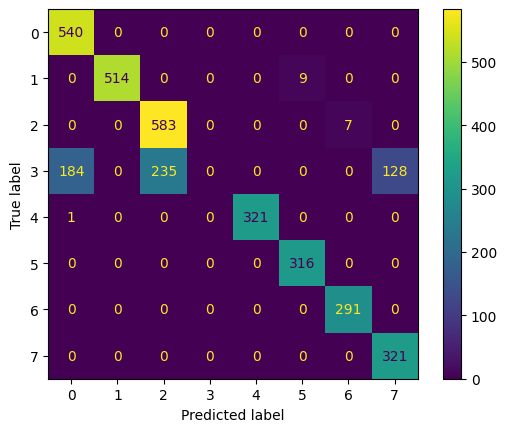

In [ ]:
# Calcular matriz de confusão 8x8
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model(torch.Tensor(X_test).to(device).to(torch.float64)).cpu().detach().numpy().argmax(1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

### Com momentum

In [ ]:
train_dataloader = DataLoader(ClassesDataset(np.c_[X_train, y_train.astype("int8")]), batch_size=128)
val_dataloader = DataLoader(ClassesDataset(np.c_[X_test, y_test.astype("int8")]), batch_size=128)

In [ ]:
model = ClassesNeuralNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

ClassesNeuralNet(
  (elu): ELU(alpha=1.0)
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=8, bias=True)
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update dos gradientes. Isso tudo só existe se for passagem por referencia
        optimizer.zero_grad() # Zera o gradiente pro proximo

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

Streaming output truncated to the last 5000 lines.

Epoch 287
-------------------------------
loss: 1.451853  [  128/13796]
loss: 1.438125  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459943 

Epoch 288
-------------------------------
loss: 1.451816  [  128/13796]
loss: 1.438084  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459916 

Epoch 289
-------------------------------
loss: 1.451780  [  128/13796]
loss: 1.438042  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459889 

Epoch 290
-------------------------------
loss: 1.451743  [  128/13796]
loss: 1.438000  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459862 

Epoch 291
-------------------------------
loss: 1.451708  [  128/13796]
loss: 1.437959  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459836 

Epoch 292
-------------------------------
loss: 1.451672  [  128/13796]
loss: 1.437918  [12928/13796]
Test Error: 
 Accuracy: 81.8%, Avg loss: 1.459810 

Epoch 293
--------------

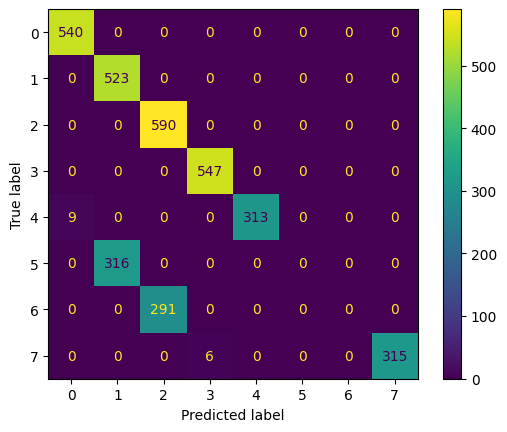

In [ ]:
# Calcular matriz de confusão 8x8
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model(torch.Tensor(X_test).to(device).to(torch.float64)).cpu().detach().numpy().argmax(1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

# Questão 4

In [ ]:
def func_ts(k):
  n = np.linspace(-10, 10, k, endpoint=0)
  xn = np.sin(n)**2 + np.cos(n + np.cos(n))
  return xn

In [ ]:
N = 1000

def create_dataset(n):
    x = func_ts(13*N)
    X = []
    y = []
    for i,v in enumerate(x):
        if len(x[i:10+i]) < 10 or len(x[10+i:13+i]) < 3:
            break
        X.append(x[i:10+i])
        y.append(x[10+i:13+i])

    return np.array(X), np.array(y)

X, y = create_dataset(N)

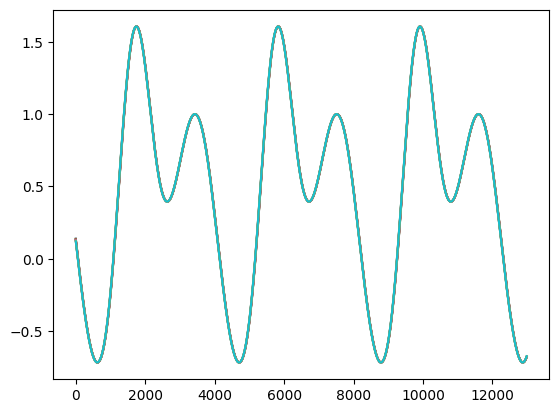

In [ ]:
plt.plot(X)
plt.show()

In [ ]:
class TemporalSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx, :10]
        y = self.data[idx, 10:]
        return X, y

In [ ]:
X.shape, y.shape

((12988, 10), (12988, 3))

In [ ]:
size = len(X)

perc = int(size*0.7)

X_train = X[:perc]
y_train = y[:perc]
X_test = X[perc:]
y_test = y[perc:]

perc

9091

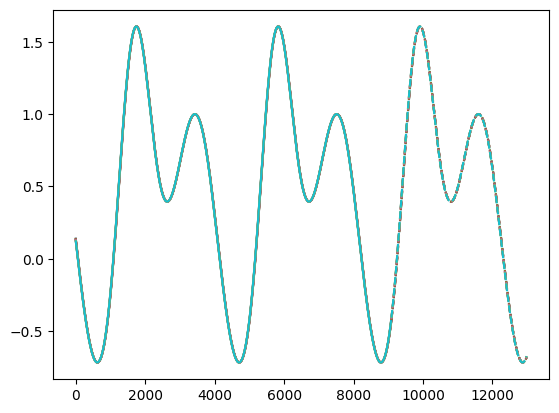

In [ ]:
plt.plot(np.arange(perc), X_train)
plt.plot(np.arange(perc, size), X_test, "--")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

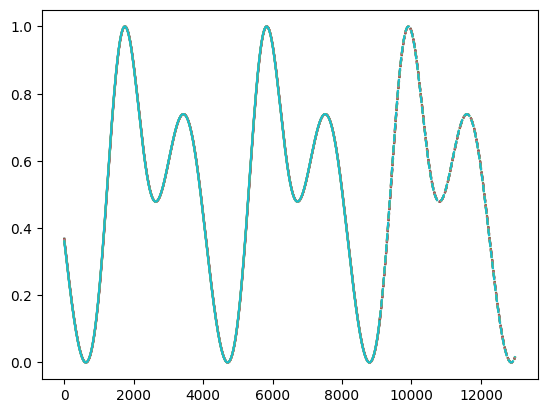

In [ ]:
plt.plot(np.arange(perc), X_train)
plt.plot(np.arange(perc, size), X_test, "--")
plt.show()

In [ ]:
train_dataloader = DataLoader(TemporalSeriesDataset(np.c_[X_train, y_train]), batch_size=64)
val_dataloader = DataLoader(TemporalSeriesDataset(np.c_[X_test, y_test]), batch_size=64)

In [ ]:
class TemporalSeriesNeuralNet(nn.Module):
    def __init__(self, layers):
        super(TemporalSeriesNeuralNet, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(layers[0], layers[1], dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(layers[1], layers[2], dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(layers[2], layers[3], dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(layers[3], layers[4], dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(layers[4], layers[5], dtype=torch.float64)
        )


    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [ ]:
model = TemporalSeriesNeuralNet([10, 16, 32, 32, 16, 3]).to(device)
print(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.00000001

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    loss_list = []
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.DoubleTensor)
        X = X.to(torch.float64)
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Faz o update print(torch.round(pred[0]))
        optimizer.zero_grad() # Zera o gradiente pro proximo

        loss_list.append(loss.item())
        train_loss += loss.item()

        if batch % 100 == 0:
            loss_, current = loss.item(), (batch + 1) * len(X)

            print(f"loss: {loss_:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    print(f"Train Error: \n Avg loss: {train_loss:>8f} \n")

    return loss_list

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    loss_list = []
    with torch.no_grad():
        for batch, (X, y) in  enumerate(dataloader):
            X = X.to(torch.float64)
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_at_this_iteration = loss_fn(pred, y).item()
            test_loss += loss_at_this_iteration
            loss_list.append(loss_at_this_iteration)
            # correct += (pred[0] - y).type(torch.float).sum().item()
            if batch % 100 == 0:
                current = (batch + 1) * len(X)

                print(f"loss: {loss_at_this_iteration:>7f}  [{current:>5d}/{size:>5d}]")
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return loss_list

TemporalSeriesNeuralNet(
  (linear_layers): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [ ]:
epochs = 1000
loss_total_train = []
loss_total_eval = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, loss_fn, optimizer)
    loss_total_train.append(np.mean(loss_train))
    loss_eval = test(val_dataloader, model, loss_fn)
    loss_total_eval.append(np.mean(loss_eval))
print("Done!")

Streaming output truncated to the last 5000 lines.

loss: 0.020992  [   64/ 3897]
Test Error: 
 Avg loss: 0.374533 

Epoch 547
-------------------------------
loss: 0.000147  [   64/ 9091]
loss: 0.000480  [ 6464/ 9091]
Train Error: 
 Avg loss: 0.000287 

loss: 0.020336  [   64/ 3897]
Test Error: 
 Avg loss: 0.370370 

Epoch 548
-------------------------------
loss: 0.000236  [   64/ 9091]
loss: 0.000580  [ 6464/ 9091]
Train Error: 
 Avg loss: 0.000296 

loss: 0.019711  [   64/ 3897]
Test Error: 
 Avg loss: 0.365306 

Epoch 549
-------------------------------
loss: 0.000357  [   64/ 9091]
loss: 0.000771  [ 6464/ 9091]
Train Error: 
 Avg loss: 0.000321 

loss: 0.019060  [   64/ 3897]
Test Error: 
 Avg loss: 0.359122 

Epoch 550
-------------------------------
loss: 0.000526  [   64/ 9091]
loss: 0.001103  [ 6464/ 9091]
Train Error: 
 Avg loss: 0.000379 

loss: 0.018333  [   64/ 3897]
Test Error: 
 Avg loss: 0.351339 

Epoch 551
-------------------------------
loss: 0.000769  [   64/ 9091]

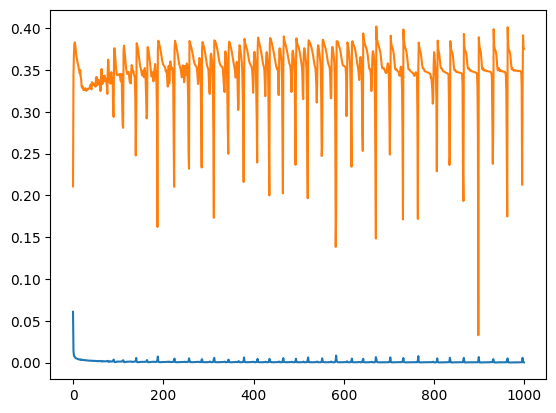

In [ ]:
plt.plot(loss_total_train, label='Erro do treino')
plt.plot(loss_total_eval, label='Erro do teste')
plt.legend()
plt.show()

In [ ]:
y_pred = model(torch.Tensor(X_test).to(device).to(torch.float64))

In [ ]:
y_pred[0]

tensor([0.1227, 0.1215, 0.1224], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [ ]:
y_test[0]

array([0.13420044, 0.13509736, 0.1359972 ])

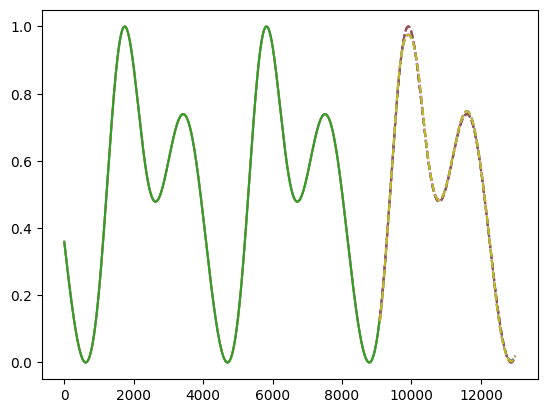

In [ ]:
plt.plot(np.arange(perc), y_train)

plt.plot(np.arange(perc, size), y_test, "--")
plt.plot(np.arange(perc, size), y_pred.cpu().detach().numpy(), "--")
plt.show()